In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sat Dec  5 00:51:13 2020

@author: keyen
"""

# -*- coding: utf-8 -*-
"""
Created on Sat Dec  5 00:47:30 2020

@author: keyen
"""

# -*- coding: utf-8 -*-
"""
Created on Fri Dec  4 01:05:10 2020

@author: keyen
"""

# -*- coding: utf-8 -*-
"""
Created on Fri Dec  4 01:04:53 2020

@author: keyen
"""


import csv
import numpy
import pandas as pnd

import matplotlib.pyplot as plt


import pandas as pnd
import numpy as np
from scipy import stats
import scipy.linalg as lnA
import matplotlib.pyplot as plt
import seaborn as sn




# Normalize the dataset
## implemenation of min-max scaling

def normalized_vector(vector):
    fmax=vector.max(axis=0)
    fmin=vector.min(axis=0)

    temp1=(vector-fmin)/(fmax-fmin)


    return temp1

# Mean subtracted data

def meansubtract(data):

    mean=data.mean(axis=0)
    meansubdata=data-mean

    return meansubdata


def filereadcsv(filename):
    import csv
    from numpy import genfromtxt
    fields=[]
    rows=[]
    with open(filename, 'r') as csvfile:
        csvreader=csv.reader(csvfile)
        fields = next(csvreader)
        key=genfromtxt(filename, delimiter=',')
        for row in csvreader:
            rows.append(row)
    return key


#def preprocess_trialdata(filedir):
def trialdataprocess():

#Column names
    columnname=['Fp1', 'AF3', 'F7', 'F3', 'FC5', 'FC1', 'T7', 'C3', 'CP5', 'CP1', 'P7', 'P3', 'PO3', 'Pz', 'O1', 'Oz', 'Fp2', 'AF4', 'Fz', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'F4', 'F8', 'FC6', 'P4', 'P8', 'O2','PO4']
    namecol=list(zip(columnname))
    frames1 = []
    labels=[]
    stimuli=[]
    targets=[]
    eventarrays=[]
    p=0
    for j in range(1,5):
        for i in range(1,5):
    ## filenames
            stimuliname='stimuli_'+str(j)+'_'+str(i)+'.csv'
            labelname='label_'+str(j)+'_'+str(i)+'.csv'
            targetname='target_'+str(j)+'_'+str(i)+'.csv'

    ## reading to variables
            target=filereadcsv(targetname)
            stimulus=filereadcsv(stimuliname)
            label=filereadcsv(labelname)
    # define a matrix
            raweeg=pnd.read_csv("eegdata_"+str(j)+"_"+str(i)+".csv", sep=',',header=None)
            # return raweeg.

        ## Session details()
    ## Time points index
            timearray=[]
            for k in range(0,64):
                time=round(k*1000/64)
                timearray.append(str(time)+'_ms')
    ## Event index
            eventarray=[]
            for k in range(0,len(label)):
                eventarray.append('Event_'+str(k))
    ## class label
            arrays=[]
            for k in range(0,len(label)):
                temper=numpy.repeat(eventarray[k], 64, axis=0)
                temp=[temper,timearray]
                arrays.append(numpy.array(temp))

    ## Session detain variable

            tuples = list(zip(*arrays))

    #return session details



    ## Concatenated data frame with all the trials indexed from n - big n
            frames = [];
            for k in range(0, len(label)):
                results = numpy.array(raweeg.iloc[k*32:(k+1)*32])
                df_tmp = pnd.DataFrame(results.T)
                frames.append(df_tmp)
            eventarray=[]
            for u in range(0,len(label)):

                eventarray.append('Event_'+str(p))

                p=p+1

            dfd = pnd.concat(frames, axis=0)

            dfd.columns=columnname


            frames1.append(dfd)
            labels.append(label)
            stimuli.append(stimulus)
            targets.append(target)
            eventarrays.append(eventarray)

    events=[]
    for m in range(0,len(eventarrays)):
        temp=eventarrays[m];
        events.extend(temp)


    arrays=[timearray,events]
    dfg=pnd.concat(frames1,axis=0)
    dfg.reset_index(drop=True)
    ind = pnd.MultiIndex.from_product([events,timearray], names=['event', 'event_time'])
    dfdg = pnd.DataFrame(dfg.values, index=ind, columns=columnname)
    dfdg.reindex(ind)

    return dfdg, targets, stimuli, labels,eventarrays,timearray

In [3]:
## Preprocess data import them into a data frame with corresponding stimuli, label and event arrays
df,target,stimuli,label,eventarrays,timearray= trialdataprocess();


## Define the amplitude interval in consideration
## THe time vector, event details for analysis plotting etc
timevector=numpy.linspace(0,1000,64)
amplitudepoint= timevector[21]
ampind=21

electrodes=['Fz', 'Cz', 'Pz', 'Oz', 'P7', 'P3', 'P4', 'P8', 'O1', 'O2', 'C3', 'C4', 'FC1', 'FC2', 'CP1', 'CP2']
#channels = ['Fz', 'Cz', 'Pz', 'Oz', 'P7', 'P3', 'P4', 'P8']
channels = ['Fz','Cz']

#channelnumber=[1,2,3,4,5,6,7,8]
channelnumber=[1]

events=[]
for i in range(0,len(eventarrays)):
    temp=eventarrays[i];
    events.extend(temp)

labeled=[]
for i in range(0,len(eventarrays)):
    temp=label[i];
    labeled.extend(temp)
labels=np.array(labeled)

stimulis=[]
for i in range(0,len(eventarrays)):
    temp=stimuli[i];
    stimulis.extend(temp)
stimulus=np.array(stimulis)


## Data set preparation for running the algorithm
## Preprocessing
## Take data from all events into a matrix
## TRAINING DATA
traineeg=[]

#for i in range(0,len(df)):
#name='Event_'+str(i)

targeteeglist=[]
eventname=[]
for i in events:
    temp=df.loc[i]
    eventname.append(i)
    targeteeglist.append(temp)
targeteeglist=pnd.concat(targeteeglist,axis=0,keys=eventname)


for i in range(len(events)):
    traineeg.append(df.loc[events[i],channels])

traineeglist=pnd.concat(traineeg,axis=0,keys=eventname)
### ID two features that can represent the data
## Training data with all samples
trainfeaturevector=[]
trainmeanampvector=[]


for i in range(0,len(events)):
#    name='Event_'+str(i)
#    name=df.index[i*64][0]
#    tempmean=traineeglist.iloc[ampind-10:ampind+10].mean()
#    temp=traineeglist.iloc[ampind:ampind+1]

    name=events[i]
    tempmean=traineeglist.loc[name][ampind-10:ampind+10].mean()
    h=traineeglist.loc[name][:]
    tempamp=h.iloc[ampind]
    temp=(np.array(tempamp))

    print(i)
#for i in range(0,len(stimuli)):
#    temp=[];tempmean=[]
#    for j in channels:
#        temper=numpy.mean(traineeglist[i][j][ampind-10:ampind+10])
#        temp.append(traineeglist[i][j][ampind])
#        tempmean.append(temper)
    trainfeaturevector.append(temp)
    trainmeanampvector.append(tempmean)

traineegfeatures=numpy.vstack(trainfeaturevector)
trainmeanamp=numpy.vstack(trainmeanampvector)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [4]:
##CLUSTERED DATA

##  Identify the target trials for amplitude average across trials
#indice=[]
#for i in range(0,len(label)):
#    indice.append(numpy.where(label[i]==1 ))
indice=numpy.where(labels==-1)

## indices of each of trails in the dataframe
fd=numpy.array(indice[0][:])
fdx=indice[0][:]
targeteeglist=[]
eventname=[]
for i in fd:
    temp=df.loc[events[i]]
    eventname.append(events[i])
    targeteeglist.append(temp)
targeteeglist=pnd.concat(targeteeglist,axis=0,keys=eventname)

targeteegfeaturevector=[];targeteegmeanampvector=[]
for i in fd:
#    name=[]
#    name='Event_'+str(i)
#    name=df.index[i*64][0]
    name=events[i]
    tempmean=targeteeglist.loc[name][ampind-10:ampind+10].mean()
    h=targeteeglist.loc[name][:]
    tempamp=h.iloc[ampind]
    temp=(np.array(tempamp))

    print(i*3)
#for i in range(0,len(stimuli)):
#    temp=[];tempmean=[]
#    for j in channels:
#        temper=numpy.mean(traineeglist[i][j][ampind-10:ampind+10])
#        temp.append(traineeglist[i][j][ampind])
#        tempmean.append(temper)
    targeteegfeaturevector.append(temp)
    targeteegmeanampvector.append(tempmean)

targeteegfeatures=numpy.vstack(targeteegfeaturevector)
targetmeanamp=numpy.vstack(targeteegmeanampvector)


## ID the non target trials
index=numpy.where(labels==-1)
## indices of each of trails in the dataframe
fg=numpy.array(index[0][:])
fgx=index[0][:]
nontargeteeglist=[]
noneventname=[]
for i in fgx:
    temp=df.loc[events[i]]
    noneventname.append(events[i])
    nontargeteeglist.append(temp)

nontargeteeglist=pnd.concat(nontargeteeglist,axis=0,keys=noneventname)


nontrainfeaturevector=[];nontrainmeanampvector=[]
for i in fg:
#   name='Event_'+str(i)
#    name=df.index[i*64][0]
    name=events[i]
    tempmean=nontargeteeglist.loc[name][ampind-10:ampind+10].mean()
    h=nontargeteeglist.loc[name][:]
    tempamp=h.iloc[ampind]
    temp=(np.array(tempamp))

    print(i)
#for i in range(0,len(stimuli)):
#    temp=[];tempmean=[]
#    for j in channels:
#        temper=numpy.mean(traineeglist[i][j][ampind-10:ampind+10])
#        temp.append(traineeglist[i][j][ampind])
#        tempmean.append(temper)
    nontrainfeaturevector.append(temp)
    nontrainmeanampvector.append(tempmean)

nontraineegfeatures=numpy.vstack(nontrainfeaturevector)
nontrainmeanamp=numpy.vstack(nontrainmeanampvector)


### Feature Reduction


## PCA
#array1=numpy.array(df.loc['Event_1'])
#normeeg=normalized_vector(array1)
#eeg=meansubtract(normeeg)
#covariance=covarianceMatrix(eeg)
#eigenvectors=eigenPCA(covariance)
#pcaeeg=principalComponents(eeg, eigenvectors, 2)



###### SKI LEARN SVM

0
3
6
9
15
21
24
27
30
33
36
42
45
48
51
54
60
63
66
69
72
78
81
84
87
90
96
99
102
105
108
111
114
117
120
126
129
135
138
141
147
150
153
156
159
162
165
168
171
177
180
183
189
192
195
201
204
207
210
213
216
219
222
228
231
234
237
243
246
249
252
255
258
261
264
273
276
279
282
285
288
291
297
300
303
309
312
315
318
321
324
327
330
333
336
342
345
348
354
357
360
363
369
372
375
378
381
384
390
393
396
399
402
408
411
414
420
423
426
429
432
438
441
444
447
450
453
459
462
465
468
471
477
480
483
486
489
495
498
501
504
507
510
513
516
522
525
531
534
537
543
546
549
552
555
558
564
567
570
573
576
579
582
588
591
594
597
600
603
606
615
618
621
624
627
630
633
639
642
645
651
654
657
660
663
669
672
675
678
681
684
687
690
693
699
702
705
708
714
717
723
726
729
732
735
738
741
744
747
750
756
759
762
768
771
774
777
780
783
786
792
795
798
801
807
813
816
819
822
825
828
834
837
840
843
846
849
855
858
861
864
867
870
873
876
882
885
888
891
894
900
906
909
912
915
918
921
927


[[389  55]
 [ 89  16]]
              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84       444
         1.0       0.23      0.15      0.18       105

    accuracy                           0.74       549
   macro avg       0.52      0.51      0.51       549
weighted avg       0.70      0.74      0.72       549



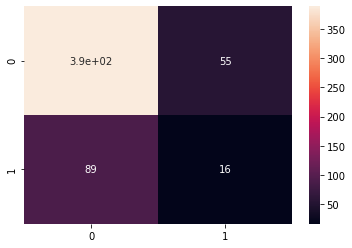

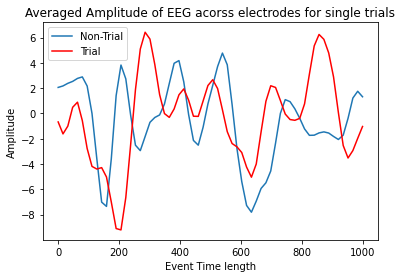

In [9]:
import pandas as pnd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

labels[labels==-1]=0

## Q1: Load the dataset
#=pnd.read_csv("iris (1).data", sep=',', names=["SepLen","SepWid","PetLen","PetWid","Species"])
X = trainmeanamp
y = labels

# Q2: Split the dataset
#Split the dataset for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

## Q3 : Train the dataset
svclassifier = SVC(kernel='sigmoid')
svclassifier.fit(X_train, y_train)

## Q4 : Test the datset
y_pred = svclassifier.predict(X_test)

plt.figure()
## Q5: Permormance of model
print(confusion_matrix(y_test,y_pred))
sn.heatmap((confusion_matrix(y_test,y_pred)),annot=True)
## Q6 : Accuracy of the classification
print(classification_report(y_test,y_pred))


######

######
#######
##Multiclass KNN

#y=stimulus
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

#from sklearn.neighbors import KNeighborsClassifier
#knn = KNeighborsClassifier(n_neighbors = 6).fit(X_train, y_train)

# accuracy on X_test
#accuracy = knn.score(X_test, y_test)
#print(accuracy)

# creating a confusion matrix
#knn_predictions = knn.predict(X_test)
#cm = confusion_matrix(y_test, knn_predictions)
#print(cm)

#print(confusion_matrix(y_test,y_pred))
#plt.imshow(confusion_matrix(y_test,y_pred))
## Q6 : Accuracy of the classification
#print(classification_report(y_test,y_pred))

plt.figure()
plt.plot(timevector,(df.loc[events[1]].mean(axis=1)),label='Non-Trial')
plt.plot(timevector,(df.loc[events[4]].mean(axis=1)),'r',label='Trial');
plt.legend()
plt.xlabel('Event Time length')
plt.ylabel('Amplitude')
plt.title('Averaged Amplitude of EEG acorss electrodes for single trials')
plt.show()

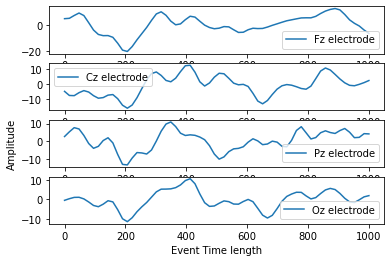

In [6]:
timevector=numpy.linspace(0,1000,64)
plt.figure()
ax=plt.gca()


ax1=plt.subplot(411)
plt.plot(timevector,df.loc[events[4],'Fz'],label='Fz electrode')
plt.legend()
#ax1.set_xlabel('Event Time length')
#ax1.set_ylabel('Amplitude')
#ax1.set_title('Fz')


ax2=plt.subplot(412)
plt.plot(timevector,df.loc[events[4],'Cz'],label='Cz electrode')
plt.legend()
#ax2.set_xlabel('Event Time length')
#ax2.set_ylabel('Amplitude')
#ax2.set_title('Cz')


ax3=plt.subplot(413)
plt.plot(timevector,df.loc[events[4],'Pz'],label='Pz electrode')
plt.legend()
#ax3.set_xlabel('Event Time length')
#ax3.set_ylabel('Amplitude')
#ax3.set_title('Pz')


ax4=plt.subplot(414)
plt.plot(timevector,df.loc[events[4],'Oz'],label='Oz electrode')
plt.legend()
#ax4.set_xlabel('Event Time length')
#ax4.set_ylabel('Amplitude')
#ax4.set_title('Oz')
ax4.set_xlabel('Event Time length')
ax3.set_ylabel('Amplitude')

plt.show()

In [7]:
# -*- coding: utf-8 -*-


import pandas as pnd
import numpy as np
import random
from scipy import stats
import seaborn as sn
import matplotlib.pyplot as plt


#Implementation of Bubble Sort function
def bubbleSort(arr):
    import copy as copy
    temp=copy.copy(arr)
    n = len(temp)
    ind = []
    for i in range(n):
        for j in range(0, n-i-1):
            if temp[j]>temp[j+1]:
                temp[j], temp[j+1] = temp[j+1], temp[j]

    for i in range(n):
        temparray=copy.copy(arr)
        #temparray=temparray.tolist()
        ind.append(temparray.index(temp[i]))

    temp=np.array(temp)
    ind=np.array(ind)
    return temp, ind


## Euclidean Distance

def euclidiandistance(vector1,vector2):
    term=[]
    for i in range(len(vector2)-1):
        temp=0
        temp=(vector1[i]-vector2[i])**2
        term.append(np.sqrt(temp))
    distance = np.sum(term)
    return distance

#nearest neighbor

#### KNN Algo
k=3
distancetoeachpoint=[]

testrecord=traineegfeatures
kneighbors=[]
neighborlabel=[]
prediction=[]
predictioncalc=[]
for i in range(0,len(traineegfeatures)):
    distancetoeachpoint=[]
    sortedarray=[]
    ind=[]

    for j in range(0,522):
        comparisondata=testrecord[j]
        if euclidiandistance(testrecord[i],comparisondata)==0.:
            continue
        else:
            distancetoeachpoint.append(euclidiandistance(testrecord[i],comparisondata))


    sortedarray,ind=bubbleSort(distancetoeachpoint)

    kneighbors.append(sortedarray[0:k])
    neighborlabel.append(labels[ind[0:k]])
    predictioncalc.append(stats.mode(neighborlabel[i]))
    prediction.append(predictioncalc[i][0][0])

correctlabel=labels


species=[0,1]
accuracy=[]
erind=[]
for i in range(0,522):
    if correctlabel[i]==prediction[i]:
        accuracy.append('correct')
    else:
        accuracy.append('incorrect')
        #erind.append()
        print(i)
        print(events[i])
        print('Sample '+str(events[i])+' is classified incorrectly' )
        print('Predicted class --> '+str(prediction[i]))
        print('But the actual class ----> '+str(correctlabel[i]))
        print('-------------------------------------------------------------')

6
Event_6
Sample Event_6 is classified incorrectly
Predicted class --> 0.0
But the actual class ----> 1.0
-------------------------------------------------------------
12
Event_12
Sample Event_12 is classified incorrectly
Predicted class --> 1.0
But the actual class ----> 0.0
-------------------------------------------------------------
13
Event_13
Sample Event_13 is classified incorrectly
Predicted class --> 0.0
But the actual class ----> 1.0
-------------------------------------------------------------
19
Event_19
Sample Event_19 is classified incorrectly
Predicted class --> 0.0
But the actual class ----> 1.0
-------------------------------------------------------------
25
Event_25
Sample Event_25 is classified incorrectly
Predicted class --> 0.0
But the actual class ----> 1.0
-------------------------------------------------------------
30
Event_30
Sample Event_30 is classified incorrectly
Predicted class --> 1.0
But the actual class ----> 0.0
---------------------------------------

['correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'incorrect', 'correct', 'correct', 'correct', 'correct', 'correct', 'incorrect', 'incorrect', 'correct', 'correct', 'correct', 'correct', 'correct', 'incorrect', 'correct', 'correct', 'correct', 'correct', 'correct', 'incorrect', 'correct', 'correct', 'correct', 'correct', 'incorrect', 'incorrect', 'correct', 'correct', 'incorrect', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'incorrect', 'correct', 'correct', 'incorrect', 'correct', 'correct', 'correct', 'incorrect', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'incorrect', 'correct', 'correct', 'correct', 'incorrect', 'correct', 'correct', 'correct', 'incorrect', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'correct', 'incorrect', 'correct', 'correct', 'correct', 'correct', 'incorrect', 'correct', 'correct', 'correct', 'correct', 'incorrect', 'correct', 'correct

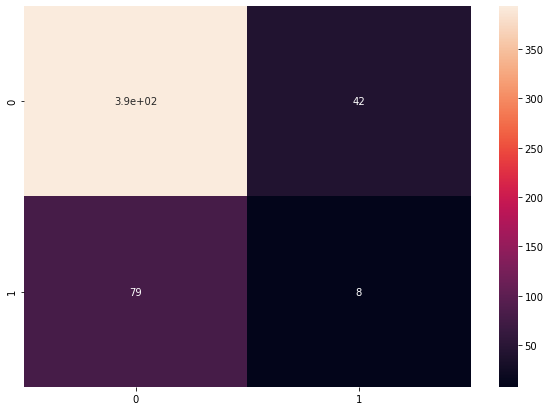

In [8]:
a21=0
a31=0
a12=0
a32=0
a23=0
a13=0
a22=0
a11=0
a33=0


for i in range(0,522):

    if prediction[i]==species[0] and correctlabel[i] == species[0]:
        a11+=1
    elif prediction[i]==species[0] and correctlabel[i] == species[1]:
        a21+=1
#    elif prediction[i]==species[0] and correctlabel[i] == species[2]:
#        a31+=1

    if prediction[i]==species[1] and correctlabel[i] == species[0]:
        a12+=1
    elif prediction[i]==species[1] and correctlabel[i] == species[1]:
        a22+=1
#    elif prediction[i]==species[1] and correctlabel[i] == species[2]:
#        a32+=1

#    if prediction[i]==species[2] and correctlabel[i] == species[0]:
#        a13+=1
#    elif prediction[i]==species[2] and correctlabel[i] == species[1]:
#        a23+=1
#    elif prediction[i]==species[2] and correctlabel[i] == species[2]:
#        a33+=1

#a11=50-a21-a31
#a22=50-a12-a32
#a33=50-a13-a23


A=[[a11,a12,a13],[a21,a22,a23],[a31,a32,a33]]

A=[[a11,a12],[a21,a22]]
    
plt.figure(figsize = (10,7))
sn.heatmap(A, annot=True)

print(accuracy)


    ####### Shit downside